# Introducción

En el siguiente ejercicio, se mezclan dos imagenes parametrizadas.

Una de las imagenes se va a representar como el background de la resultante, mientras que la otra imagen se va a montar al frente (solo aquellos pixeles que sean de color negro).

Para ello, se toman todos los pixeles y se los compara con el RGB negro [0, 0, 0]. Si el pixel tomado es de color negro se deja al frente de la imagen resultante; para todos los pixels que no sean de color negro se toman los pixeles de la imagen de background.

Con este ejercicio, se pretende entender el funcionamiento basico del Lenguaje Python [1], Google Colab [2,3] y tratamiento de imagenes a bajo nivel.

En este ejercicio en particular, tambien se pretende entender el funcionamiento en paralelo con mas de una dimensión y poder comparar los resultados con la versión en serie.

---
# Armado del ambiente
Se toman la dirección web de dos imagenes.

1 - En blanco y negro.

2 - Una imagen en color que se representara como background de la imagen resultante.

Ambas imagenes se las deja disponible en el contexto del cuaderno Colab.

In [52]:
#@title ## Parámetros de ejecución

#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://i.pinimg.com/originals/be/4a/98/be4a98faeda134f012cc442bd67536a7.jpg" #@param {type:"string"}

#@markdown ---
#@markdown ### Especifique la URL del background:
background_img = "https://previews.123rf.com/images/hollygraphic/hollygraphic1607/hollygraphic160700009/61610728-resumen-de-antecedentes-las-formas-geom%C3%A9tricas-de-colores-poligonal-vector-de-textura-colores-del-arco.jpg" #@param {type:"string"}

!wget {url_imagen} -O imagen.jpg
!wget {background_img} -O background_img.jpg


--2020-11-19 00:22:16--  https://i.pinimg.com/originals/be/4a/98/be4a98faeda134f012cc442bd67536a7.jpg
Resolving i.pinimg.com (i.pinimg.com)... 199.232.64.84, 2a04:4e42:46::84
Connecting to i.pinimg.com (i.pinimg.com)|199.232.64.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72849 (71K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>]  71.14K  --.-KB/s    in 0.001s  

2020-11-19 00:22:16 (56.2 MB/s) - ‘imagen.jpg’ saved [72849/72849]

--2020-11-19 00:22:16--  https://previews.123rf.com/images/hollygraphic/hollygraphic1607/hollygraphic160700009/61610728-resumen-de-antecedentes-las-formas-geom%C3%A9tricas-de-colores-poligonal-vector-de-textura-colores-del-arco.jpg
Resolving previews.123rf.com (previews.123rf.com)... 104.111.90.201
Connecting to previews.123rf.com (previews.123rf.com)|104.111.90.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102247 (100K) [image/jpeg]
Saving to: ‘background_img

---
## Instala el modulo CUDA de Python en el cuaderno.

In [ ]:
!pip install pycuda

# Desarrollo - Ejecución CPU-GPU.

Combinación de dos imagenes.

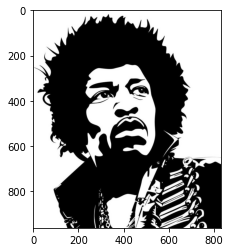

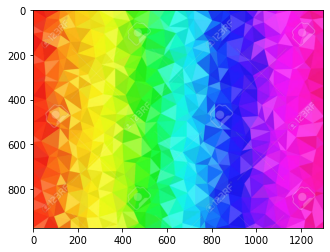

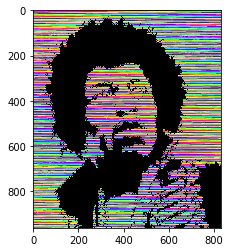

Tiempo en procesar las imagenes: 0.076 [ms]
Tiempo de representacion de las imagenes: 598.62 [ms]
Tiempo Total: 640.806 [ms]


In [58]:
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
from matplotlib import pyplot as plt

tiempo_total = datetime.now()

# ------------------------------------------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos --------------
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# ------------------------------------------------------------------------------

# Cargo la imagen y el background. ---------------------------------------------
try:
    imagepath = 'imagen.jpg'
    image = Image.open(imagepath)

    imagepath = 'background_img.jpg'
    background = Image.open(imagepath)
except IOError:
    print("No se pudo abrir la imagen de la url: ", imagepath)

# Proporciones de la imagen y del background. ---------------------------------- 
img_alto, img_ancho = image.size 
back_alto, back_ancho = background.size 
  
try:
  if (img_alto > back_alto) or (img_ancho > back_ancho):
    raise ValueError("El background debe ser de un tamaño igual o superior al de la imagen.");

  # Convierto la imagen comprimida en JPEG/PNG a array. ------------------------
  img_cpu = numpy.asarray(image)
  back_cpu = numpy.asarray(background)
  result_cpu = numpy.empty_like(img_cpu)

  # Reservo memoria en GPU. ----------------------------------------------------
  img_gpu = cuda.mem_alloc(img_cpu.nbytes)
  back_gpu = cuda.mem_alloc(back_cpu.nbytes)
  result_gpu = cuda.mem_alloc(result_cpu.nbytes)

  # GPU - Copio la memoria al GPU. ---------------------------------------------
  cuda.memcpy_htod(img_gpu, img_cpu)
  cuda.memcpy_htod(back_gpu, back_cpu)
  cuda.memcpy_htod(respuesta_gpu, result_cpu)

  # CPU - Defino la función kernel que ejecutará en GPU.
  module = SourceModule("""
  __global__ void kernel_img(int ancho, int alto, char *img, char *back, char *result) {
    // Calculo las coordenadas del Thread en dos dimensiones.
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    int idy = threadIdx.y + blockIdx.y*blockDim.y;

    // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
    if( idx < ancho && idy < alto )
    {
      int pixelR = 0;
      int pixelG = 0;
      int pixelB = 0;
      int index = (idx+(idy*ancho))*3;

      int RI = (int) img[index];
      int GI = (int) img[index+1];
      int BI = (int) img[index+2];

      int RB = (int) back[index];
      int GB = (int) back[index+1];
      int BB = (int) back[index+2];

      if(RI + GI + BI == 0) {
        pixelR = RI;
        pixelG = GI;
        pixelB = BI;
      } else {
        pixelR = RB;
        pixelG = GB;
        pixelB = BB;
      }

      // Escribo el color del pixel.
      result[index]   = pixelR;
      result[index+1] = pixelG;
      result[index+2] = pixelB;
    }
  }
  """) 

  # CPU - Genero la función kernel. --------------------------------------------
  kernel = module.get_function("kernel_img")

  tiempo_img = datetime.now()

  # Se calculan las dimensiones de trabajo. ------------------------------------
  dim_hilo_x = 16
  dim_bloque_x = numpy.int((img_ancho+dim_hilo_x-1) / dim_hilo_x)

  dim_hilo_y = 19
  dim_bloque_y = numpy.int((img_alto+dim_hilo_y-1) / dim_hilo_y)

  kernel(numpy.int32(img_ancho), numpy.int32(img_alto), img_gpu, back_gpu, result_gpu, block=(dim_hilo_x, dim_hilo_y, 1), grid=(dim_bloque_x, dim_bloque_y,1))

  tiempo_img = datetime.now() - tiempo_img
  tiempo_representacion = datetime.now()

  # GPU - Copio el resultado desde la memoria GPU. -----------------------------
  cuda.memcpy_dtoh(result_cpu, result_gpu)

  # Muestro la imagen original. ------------------------------------------------
  plt.figure()
  plt.imshow(img_cpu)
  plt.show()

  # Muestro el background original. --------------------------------------------
  plt.imshow(back_cpu)
  plt.show()

  # Muestro la imagen resultante. ----------------------------------------------
  plt.imshow(result_cpu, interpolation='nearest')
  plt.show()

  tiempo_representacion = datetime.now() - tiempo_representacion 
  tiempo_total = datetime.now() - tiempo_total

  print( "Tiempo en procesar las imagenes:", tiempo_en_ms(tiempo_img), "[ms]")
  print( "Tiempo de representacion de las imagenes:", tiempo_en_ms(tiempo_representacion), "[ms]")
  print( "Tiempo Total:", tiempo_en_ms(tiempo_total), "[ms]")

except ValueError as valerr:
  print (valerr)
# except: 
#   print("Houston we have a problem!")



---
# 4 Tabla de pasos


 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  wget url_imagen       | Lectura de la direcciòn URL de la imagen (jpg) a procesar.
CPU      | pip install pycuda    | Instala en el cuaderno los driver de CUDA para Python.
CPU      |  matplotlib inline    | Macro de Colab para mostrar imagenes.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  Image.open()          | Abre el archivo de la imagen.
CPU      |  numpy.asarray(imagen) | Convierte el formato comprimido JPG a RAW.
CPU      |  numpy.empty_like(()   | Genera el array destino, que tendrá a la imagen resultado. 
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria para las imagenes en GPU.
**GPU**  |  cuda.memcpy_htod()    | Copio los valores en crudo de las imagenes al GPU.
CPU      |  SourceModule()        | Posee el còdigo del kernel.
CPU      |  module.get_function() | convierte el texto del kernel en funcion de Python.
CPU      |  dim_hilo_x, dim_hilo_y| Calcula las dimensiones para la ejecuciòn de 2D.
**GPU**  |  kernel()              | Ejecuta el kernel en GPU, enviando los parametros.
CPU      |  print()               | Informa los atributos de la imagen.
CPU      | cuda.memcpy_dtoh()     | Copia desde la memoria GPU al CPU.
CPU      |  plt.imshow            | Muestra la imagen original.
CPU      |  plt.imshow            | Muestra la imagen resultado.



---
# 5 Conclusiones

Las conclusiones son explicadas en clase...

---
# 6 Bibliografía

[1] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[4] 2009, SINTESIS DIGITAL DE COLOR UTILIZANDO TONOS DE GRIS, ING. JESÚS GUSTAVO FLORES ERAÑA : [PDF](https://ninive.uaslp.mx/xmlui/bitstream/handle/i/2264/MCA1SDC00901.pdf?sequence=1&isAllowed=y)
